<center><h1>Time series analysis</h1></center>
<center><h2>Tutorial 14: Seasonal ARIMA</h2></center>
<br>

This notebook brings all the forecasting material together in a case study. Our objective is to forecast the monthly ridership in Sydney trains based on data provided by the [NSW Bureau of Transport Statistics](https://opendata.transport.nsw.gov.au/search/type/dataset). This is a fundamental policy issue for the city as population growth puts [increasing pressure](http://www.smh.com.au/nsw/revealed-new-metro-between-sydney-cbd-and-parramatta-20160831-gr5d6m.html) on public transport, with some rail lines being notorious for overcrowding. 

##### Content:

<a class="buttom" href="#>Data:-Sydney-monthly-train-journeys">Data: Sydney monthly train journeys</a><br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#ARIMA">ARIMA</a><br>
<a class="buttom" href="#Identification" style="margin-left: 10px">(a) Identification</a><br>
<a class="buttom" href="#Automatic-selection" style="margin-left: 10px">(b) Automatic selection</a><br>
<a class="buttom" href="#Estimation" style="margin-left: 10px">(c) Estimation</a><br>
<a class="buttom" href="#Diagnostics" style="margin-left: 10px">(d) Diagnostics</a><br>
<a class="buttom" href="#Exponential-smoothing">Exponential smoothing</a><br>
<a class="buttom" href="#Model-validation">Model validation</a><br>
<a class="buttom" href="#Forecast">Forecast</a><br>

Based in the work of Marcel Scharth http://www.marcelscharth.com/

This notebook assumes the following packages and settings.

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
# Predefined plots

# Time series plot
def ts_plot(y, color=red):
    fig, ax= plt.subplots(figsize=(9,6))
    y.plot(color=color, ax=ax)
    ax.set_xlabel('')
    ax.set_xticks([], minor=True)
    sns.despine()
    return fig, ax

# ACF and PACF plots
def acf_pacf_plot(y):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
    sns.despine()
    fig.tight_layout()
    return fig, ax

#Histogram
def hist(y):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(y, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

##Data: Sydney  monthly train journeys

In [9]:
data=pd.read_csv('datasets/journeys.csv', index_col='Month', parse_dates=True, dayfirst=True)
data.index=data.index.to_period()
y=data['Journeys']
data.tail()

,Journeys
Month,
2018-06,32604345
2018-07,33053594
2018-08,35713800
2018-09,33021482
2018-10,34487367


We rescale the series to be in millions of rides, to facilitate the intepretation and avoid possible numerical problems.

In [10]:
y=y/(10**6)

As a general rule, you should avoid working with large numbers since they lead to less precise numerical calculations and an accumulation of numerical precision errors. The next cell illustrates this problem. 

In [11]:
x=10**8
for i in range(1000):
    x+=0.001
print(x-10**8)

x=0
for i in range(1000):
    x+=0.001
print(x)

1.0000020265579224
1.0000000000000007


##Exploratory Data Analysis

The next figure shows the time series. 

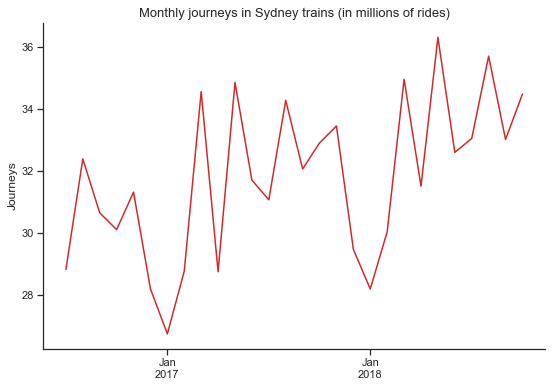

In [12]:
fig, ax= ts_plot(y)
ax.set_ylabel('Journeys')
ax.set_title('Monthly journeys in Sydney trains (in millions of rides)', fontsize=13)
plt.show()

We conduct a X13-ARIMA-SEATS decomposition for the data.  The results show that the number of journeys on Sydney trains had a slightly negative trend until 2006, but has increased steadily with a roughly linear trend since then: the number of users grew by 22% in the last ten years of the data. The series has a clear seasonal pattern that seems to be slightly growing in size with the trend. 

In [17]:
ts=y.copy()
ts.index=pd.to_datetime(ts.index.to_timestamp()) # remember that the decomposition functions only work with datetime
decomposition=sm.tsa.x13_arima_analysis(ts,x12path='.')
seasonal=decomposition.observed/decomposition.seasadj



from forecast import plot_components_x13
plot_components_x13(decomposition)
plt.show() 

X13Error: ERROR: Series to be modelled and/or seasonally adjusted must have at
        least 3 complete years of data.
  
  No seasonal adjustment this run

To better understand the seasonal pattern, the next cell draws a seasonal plot. The number of journeys peaks in March, May and August, and is lowest during the summer months. 

In [ ]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(seasonal.groupby(seasonal.index.month).mean(), color=red, marker='.', markersize=15)
ax.set_xlim(0.5,12.5)
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months, rotation='-90')
ax.set_ylabel('Seasonal index')
ax.set_title('Seasonal plot', fontsize=13)
sns.despine()
plt.show()

It is useful to save the help X13-ARIMA output for reference. 

In [ ]:
f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

##ARIMA



###Identification

To identify an appropriate ARIMA specification for the series, we start by creating a data frame to store the first differenced, seasonally differenced, and first and seasonally differenced series.

In [ ]:
df=pd.DataFrame(y.copy())
df.columns.values[0]='original'
df['first_diff']=y-y.shift(1)
df['seasonal_diff']=y-y.shift(12)
df['diff']=df['first_diff']-df['first_diff'].shift(12)
df=df.dropna()
df.tail().round(3)

Taking the first difference reveals a slow decay in ACF at the seasonal lags, suggesting the need for seasonal difference to  stationarity. 

In [ ]:
ts_plot(df['first_diff'])
plt.title('First difference')
plt.show()

In [ ]:
acf_pacf_plot(df['first_diff'])
plt.show()

Taking only the seasonal difference leads to a still clearly nonstationary series, confirming the need for both transformations. 

In [ ]:
ts_plot(df['seasonal_diff'])
plt.title('Seasonal difference')
plt.show()

In [ ]:
acf_pacf_plot(df['seasonal_diff'])
plt.show()

The next figure shows the first and seasonally differenced series, followed by the ACF and PACF plots. The ACF and PACF plots suggest the an AR(2) model: since the autocorrelations decrease gradually, while the partial autocorrelations display a clear cut-off after lag 2. 

In [ ]:
ts_plot(df['diff']) # first and seasonal difference
plt.title('First and seasonal difference')
plt.show()

In [ ]:
acf_pacf_plot(df['diff'])
plt.show()

No seasonal AR or MA pattern is easily discernible from the ACF and PACFs plots above. Hence, I fit an AR(2) to model to the first and seasonally differenced series and examine the residuals for the remaining autocorrelations. The ACF and PACF plots for the residulal series seem to be consistent with a seasonal MA(1) model, due to a significant autocorrelation at lag 12 and significant partial autocorrelations at lags 12 and 24.  

In [ ]:
arima = sm.tsa.ARIMA(df['diff'], order=(2, 0, 0)).fit()
acf_pacf_plot(arima.resid)
plt.show()

###Automatic selection

We can also conduct automatic ARIMA order selection based on the X13 ARIMA decomposition software, which is in turn based on the AIC. The automatic selection procedure confirms our choice based on the analysis of the ACF and PACF plots. In practice, it is important to use both the visual and automatic approaches and compare the results. 

In [ ]:
results=sm.tsa.x13_arima_select_order(y)
print(results.order) # non-seasonal part
print(results.sorder) # seasonal part

##Estimation

In [ ]:
sarima=sm.tsa.statespace.SARIMAX(y,  order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
print(sarima.summary())

###Diagnostics


In [ ]:
resid=sarima.resid[13:] # the first 13 residuals are inialisation ones

Below are the residual plot, ACF and PACF for the ARIMA(2,1,0)(0,1,1) model. Therea are no apparent patterns in these plots, so that model seems to adequately capture time series dependence in the date.

In [ ]:
ts_plot(resid, color=blue)
plt.title('Residual plot')
plt.show()

In [ ]:
acf_pacf_plot(resid)
plt.show()

The histogram of the residuals is consistent with a normal or near normal distribution.

In [ ]:
hist(resid)
plt.show()

This part of the model output gives further information. The distribution of the residuals is approximately symmetric and displays near Gaussian sample kurtosis, such that we do not reject the null hypothesis of normality. 

In [ ]:
sarima.summary().tables[2]

The output also shows hypothesis tests for no serial correlation and constant variance (both of which we do not reject). 

##Exponential Smoothing

###Estimation

I estimate several Holt-Winters specifications, allowing for additive or multiplicative seasonality, a damped trend, and a log transformation. When modelling the level of the series,  the model selection criteria and the overall fit suggest that a multiplicative model without damping is the preferred specification for the data. Later, we will use a validation set to select between the multiplicative and log-additive models. 

In [ ]:
import forecast

ahw=forecast.holtwinters(y, additive=True, damped=False, m=12)
ahw.fit()
ahw.summary()

In [ ]:
ahwd=forecast.holtwinters(y, additive=True, damped=True, m=12)
ahwd.fit()
ahwd.summary()

In [ ]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw.fit()
mhw.summary()

In [ ]:
mhwd=forecast.holtwinters(y, additive=False, damped=True, m=12)
mhwd.fit()
mhwd.summary()

In [ ]:
ahw_log=forecast.holtwinters(np.log(y), additive=True, damped=False, m=12)
ahw_log.fit()
ahw_log.summary()

###Diagnostics

The figures below show the residual plot, ACF and PACF for the multiplicative Holt-Winters model.  We find that the exponential smoothing method is not a good fit for the data due to the presence of substantial remaining autocorrelation. The autocorrelation is due to a short run behaviour that is picked up by the AR(2) part of the ARIMA model above. 

In [ ]:
resid=pd.Series(mhw.resid, index=y.index).iloc[13:]
ts_plot(resid, color=blue)
plt.title('Residual plot')
plt.show()

In [ ]:
acf_pacf_plot(resid)
plt.show()

##Model validation

We now use real-time forecasting (2010 onwards, 63 observations), to confirm whether we should prefer the ARIMA model over the methods, and to estimate how it may perform for short and medium run forecasts. We consider forecasts one month and one year ahead. 

The results clearly show that the ARIMA(2,1,0)(0,1,0) model outperforms exponential smoothing for forecasting. 

In [ ]:
# Real time forecasting

validation=y['2010':].index
start = y.index.get_loc('2010-01')

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal RW','Holt-Winters', 
                                                                'Log Holt-Winters', 'Seasonal ARIMA', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    # seasonal random walk forecast
    results.iloc[j,0]=y.iloc[i-12]
    
    # multiplicative holt winters
    model = forecast.holtwinters(y.iloc[:i] , additive=False, damped=False, m=12)
    model.fit()
    results.iloc[j,1]=model.forecast(1)[0]
    
    # log holt winters
    model = forecast.holtwinters(np.log(y.iloc[:i]), additive=True, damped=False, m=12)
    model.fit()
    results.iloc[j,2]=np.exp(model.forecast(h=1)[0]+model.forecastvariance(h=1)[0]/2)
    
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
    results.iloc[j,3]=model.forecast()[0]

In [ ]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

In [ ]:
# Real time forecasting  (One year ahead)

validation=y['2010':].index
start = y.index.get_loc('2010-01')

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['Seasonal RW','Holt-Winters', 
                                                                'Log Holt-Winters', 'Seasonal ARIMA', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    # seasonal random walk forecast
    results.iloc[j,0]=y.iloc[i-12]
    
    # multiplicative holt winters
    model = forecast.holtwinters(y.iloc[:i-12+1] , additive=False, damped=False, m=12)
    model.fit()
    results.iloc[j,1]=model.forecast(h=12)[-1]
    
    # log holt winters
    model = forecast.holtwinters(np.log(y.iloc[:i-12+1]), additive=True, damped=False, m=12)
    model.fit()
    results.iloc[j,2]=np.exp(model.forecast(h=12)[-1]+model.forecastvariance(h=12)[-1]/2)
    
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i-12+1],  order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
    results.iloc[j,3]=model.forecast(steps=12)[-1]

# The standard error is not valid in this case because the forecast errors are correlated
table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0], _ = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

##Forecast

Here are the final forecasts based on the ARIMA(2,1,0)(0,1,1) model. We predict a continuing increase in the number of train rides. 

In [ ]:
h=24 

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

y_pred = sarima.forecast(steps=h)
y_pred =  pd.Series(y_pred, index=test)

intv1 = sarima.get_forecast(h).conf_int(alpha=0.2)
intv2 = sarima.get_forecast(h).conf_int(alpha=0.1)
intv3 = sarima.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = forecast.fanchart(y['2012':], y_pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Journeys')
ax.set_title('ARIMA(2,1,0)(0,1,1) Sydney train journeys forecast', fontsize=13)
sns.despine()
plt.show()